In [1]:
from pyspark.sql.functions import mean, udf, col, round
from pyspark.sql.types import DoubleType
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark_session  = SparkSession.builder\
                        .enableHiveSupport()\
                        .getOrCreate()

spark_session.conf.set("spark.executor.memory", '8g')
spark_session.conf.set('spark.executor.cores', '13')
spark_session.conf.set('spark.cores.max', '13')
spark_session.conf.set("spark.driver.memory",'8g')
sc = spark_session.sparkContext

## import csv files into spark dataframes
Note: both files contain records from all 5 boroughs

In [3]:
df1 = spark.read.csv('data/pluto.csv', header=True)
df2 = spark.read.csv('data/pluto_18v1.csv', header=True)

In [4]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])

In [5]:
double_columns = ['bldgarea', 'facilfar',
                  'residfar', 'commfar', 'numbldgs', 'numfloors', 'bldgdepth', 
                  'bldgfront', 'lotdepth', 'lotfront', 
                  'exempttot', 'exemptland', 'builtfar']

In [6]:
# def intersection(lst1, lst2): 
#     return list(set(lst1) & set(lst2)) 
# colnames = intersection(df1.columns, df2.columns)

In [7]:
cols = df2.columns

In [8]:
df1 = df1.select(cols)
df2 = df2.select(cols)

## Type Conversion

In [9]:
for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))

## Change column names and joining dataframes
* since we are doing column comparison, we need to the column names of one df to avoid confusion
* in this case, we add "_1"_ to the name, e.g. "BBL" ==> "BBL_1"
* here we are doing an inner join because we only care about the BBL's that apeared in both dataframes

In [10]:
df1 = df1.select([col(A).alias(A+'_1') for A in df1.schema.names])

In [11]:
df1_names = df1.schema.names
df2_names = df2.schema.names
colnames = zip(df1_names, df2_names)

In [12]:
df = df2.join(df1, df2['bbl'] == df1['bbl_1'])

## Create UDF (user defined function) for column comparison
* by doing ```@udf``` decorator, we are basically telling spark to optimize this function for column wise paralellized operations (it's a black box to me) 

In [13]:
@udf
def compare(col1,col2):
    if col1!=col2:
        return 1
    else:
        return 0

## Generate results
1. generate the mismatch dummy column 
2. get rid of the original valued columns
3. calculate the mean (in this case represents the percentage of mismatches) and produce output

In [14]:
spark.sql('set spark.sql.caseSensitive=true')
for A,B in colnames:
    df = df.withColumn(B+'%', compare(col(A),col(B)))\
               .drop(A,B)
results = df.select(*[mean(col(A)).alias(A) for A in df.schema.names])

## Convert spark dataframe to pandas dataframe 
so we can easily export as a csv or conduct further analysis/visualizations

In [15]:
start_time = time.time()
results_df = results.toPandas()
elapsed_time = time.time() - start_time

In [16]:
results_df

,borough%,block%,lot%,cd%,ct2010%,cb2010%,schooldist%,council%,zipcode%,firecomp%,...,zmcode%,sanborn%,taxmap%,edesignum%,appbbl%,appdate%,plutomapid%,firm07_flag%,pfirm15_flag%,version%
0,0.0,0.0,0.0,0.023292,0.019705,0.002271,0.020593,0.020572,0.019663,0.020247,...,0.000624,0.001695,0.001434,0.000182,0.999998,0.106054,0.00105,0.000393,0.000434,1.0


In [17]:
elapsed_time

150.16519808769226

In [18]:
results_df.iloc[0,:].sort_values(ascending=False)

version%                 1.000000
appbbl%                  0.999998
ycoord%                  0.999421
xcoord%                  0.999421
exempttot%               0.417070
exemptland%              0.374899
splitzone%               0.201110
ownertype%               0.110307
appdate%                 0.106054
yearalter2%              0.097790
areasource%              0.056414
ownername%               0.055816
bsmtcode%                0.052588
sanitsub%                0.043460
landuse%                 0.029030
address%                 0.025422
sanitboro%               0.023926
tract2010%               0.023718
cd%                      0.023292
zonedist2%               0.022467
healthcenterdistrict%    0.020824
schooldist%              0.020593
council%                 0.020572
policeprct%              0.020464
bldgclass%               0.020377
healtharea%              0.020336
firecomp%                0.020247
builtfar%                0.019768
ct2010%                  0.019705
zipcode%      

In [20]:
results0 = pd.read_csv('results_17v11_18v1.csv', index_col = False)

In [21]:
results0

,Borough%,Block%,Lot%,CD%,CT2010%,CB2010%,SchoolDist%,Council%,ZipCode%,FireComp%,...,ZMCode%,Sanborn%,TaxMap%,EDesigNum%,APPBBL%,APPDate%,PLUTOMapID%,FIRM07_FLAG%,PFIRM15_FLAG%,Version%
0,0.0,0.0,0.0,0.000002,0.003492,0.001272,0.087959,0.000537,0.000772,0.000529,...,0.000297,0.003862,0.001294,0.001034,0.00219,0.07836,0.001308,0.0,0.0,1.0


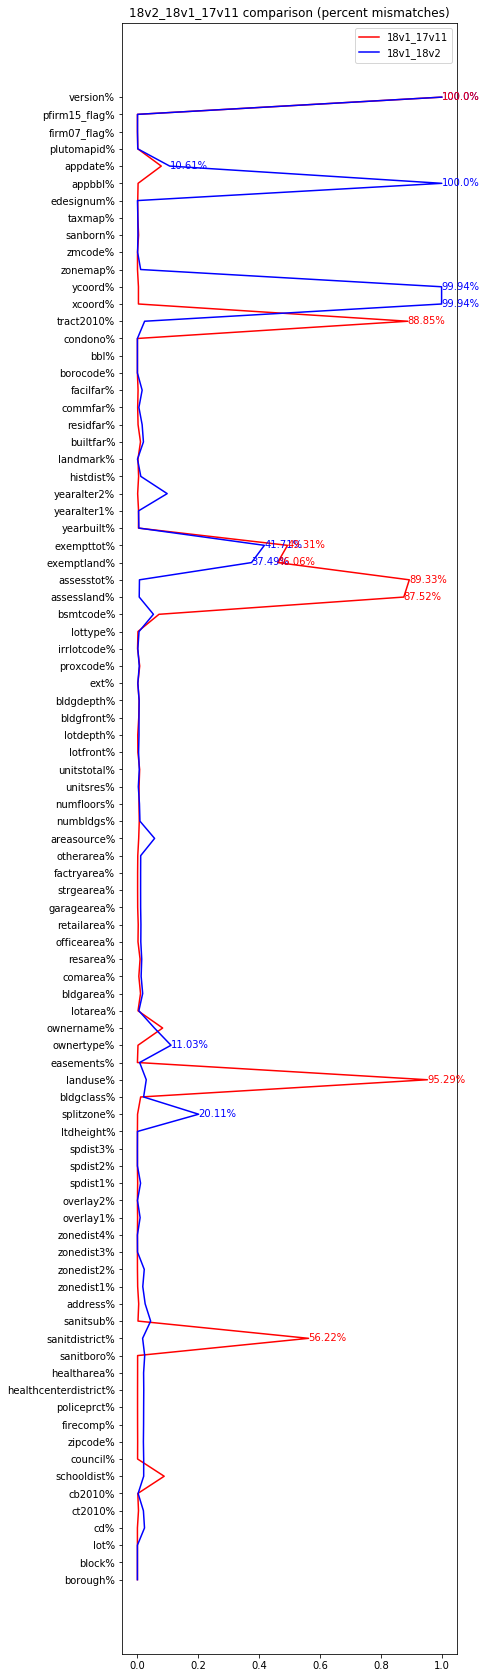

In [22]:
plt.figure(figsize=(6, 30))
plt.plot(results0.iloc[0, :], range(87), label = '18v1_17v11', color = 'red')
plt.plot(results_df.iloc[0, :], range(87), label = '18v1_18v2', color = 'blue')
label = list(results_df.iloc[0, :])
label0 = list(results0.iloc[0, :])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass
    
for i in range(len(label0)):
    if label0[i] >= 0.1:
        plt.text(x = label0[i] , y = i-0.15, s = '{}%'.format(np.round(label0[i]*100, 2)), size = 10, color = 'red')
    else: 
        pass
    
plt.yticks(range(87), results_df.columns, rotation='horizontal')
plt.title('18v2_18v1_17v11 comparison (percent mismatches)')
plt.legend()
plt.savefig('18v1_18v2_17v11_comparison.png', bbox_inches='tight')
plt.show()

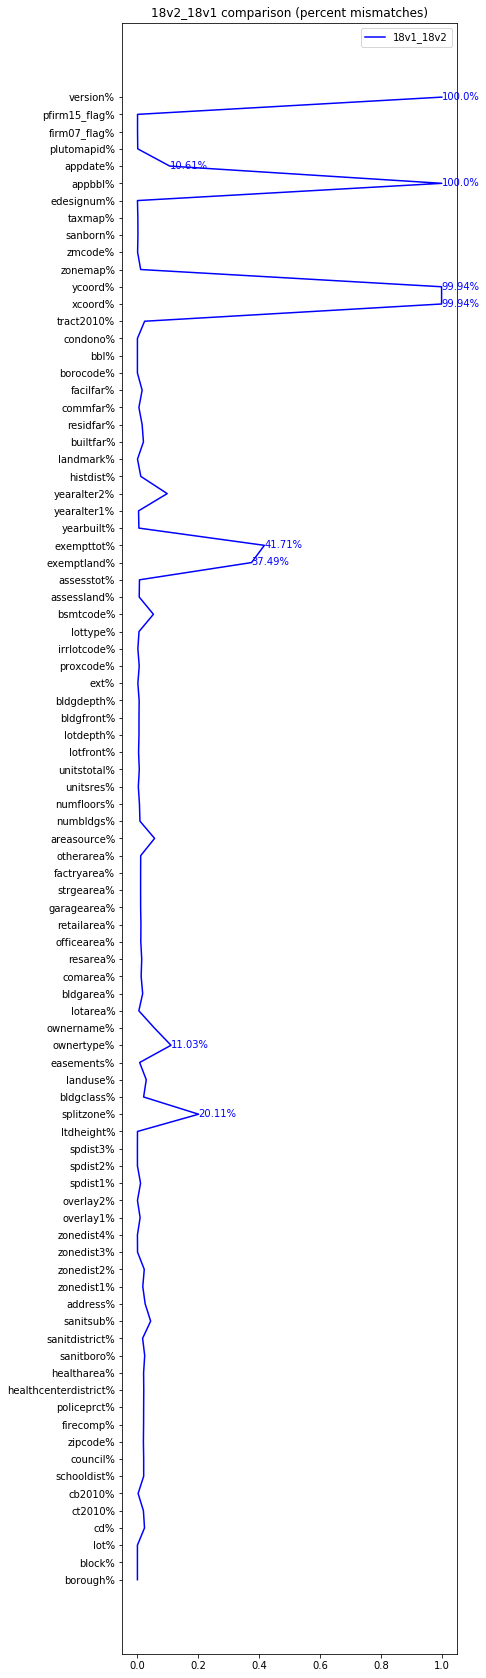

In [23]:
plt.figure(figsize=(6, 30))
plt.plot(results_df.iloc[0, :], range(87), label = '18v1_18v2', color = 'blue')
label = list(results_df.iloc[0, :])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass

plt.yticks(range(87), results_df.columns, rotation='horizontal')
plt.title('18v2_18v1 comparison (percent mismatches)')
plt.legend()
plt.savefig('18v1_18v2_comparison.png', bbox_inches='tight')
plt.show()